# Task A — EDA & Data Quality

Describe findings and visuals here.

In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option("display.max_columns", 120)
plt.style.use("seaborn-v0_8")
DATA_DIR = Path("../dataset")
sup = pd.read_csv(DATA_DIR/"suppliers.csv")
prod = pd.read_csv(DATA_DIR/"products.csv")
prices = pd.read_csv(DATA_DIR/"price_lists.csv", parse_dates=["valid_from","valid_to"])
po = pd.read_csv(DATA_DIR/"purchase_orders.csv", parse_dates=["order_date","promised_date"])
deliv = pd.read_csv(DATA_DIR/"deliveries.csv", parse_dates=["actual_delivery_date"])
po = po.merge(deliv, on="order_id", how="left")
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


### 1. Collect information about the tables

In [2]:
for df in [sup, prod, prices, po]:
    print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   supplier_id          20 non-null     int64  
 1   name                 20 non-null     object 
 2   country              20 non-null     object 
 3   preferred            20 non-null     bool   
 4   rating               20 non-null     float64
 5   base_lead_time_days  20 non-null     int64  
 6   on_time_bias         20 non-null     float64
dtypes: bool(1), float64(2), int64(2), object(2)
memory usage: 1.1+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sku             40 non-null     object 
 1   name            40 non-null     object 
 2   uom             40 non-null     object 
 3   hazard_class    40 non-null     object 


### 2. Merge purchase orders with suppliers and products

In [3]:
po = po.merge(prod, on="sku", how="left").merge(sup, on="supplier_id", how="left")

### 3. Check Missingness in Data

In [4]:
po.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4307 entries, 0 to 4306
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   order_id              4307 non-null   int64         
 1   order_date            4307 non-null   datetime64[ns]
 2   supplier_id           4307 non-null   int64         
 3   sku                   4307 non-null   object        
 4   qty                   4307 non-null   int64         
 5   unit_price            4307 non-null   float64       
 6   currency              4307 non-null   object        
 7   ship_mode             4307 non-null   object        
 8   incoterm              4307 non-null   object        
 9   payment_terms         4307 non-null   object        
 10  distance_km           4307 non-null   int64         
 11  promised_date         4307 non-null   datetime64[ns]
 12  urgent                4307 non-null   int64         
 13  order_notes       

##### Seems no missing suppliers or products

### 4. Check inconsistencies

In [5]:
assert po["delay_days"].to_list() == (po["actual_delivery_date"] - po["promised_date"]).dt.days.to_list()
assert po["late_delivery"].to_list() == (po["delay_days"] > 0).to_list()
assert (po["promised_date"] > po["order_date"]).all()

##### Seems no inconsistencies in the data

### 5. Analyze numerical and categorical columns

In [6]:
po.head()

,order_id,order_date,supplier_id,sku,qty,unit_price,currency,ship_mode,incoterm,payment_terms,distance_km,promised_date,urgent,order_notes,actual_delivery_date,late_delivery,delay_days,partial_delivery,cancelled,delay_reason,name_x,uom,hazard_class,base_price_eur,name_y,country,preferred,rating,base_lead_time_days,on_time_bias
0,1,2024-01-01,8,SKU00038,15,11.81,EUR,sea,FOB,NET30,748,2024-01-29,0,NaN,2024-01-31,1,2,0,0,none,Product 038,kg,none,12.02,Supplier 008,FR,True,3.1,27,0.192
1,2,2024-01-01,1,SKU00020,25,22.43,EUR,road,EXW,NET30,1188,2024-01-05,0,NaN,2024-01-06,1,1,0,0,none,Product 020,kg,flammable,23.19,Supplier 001,US,True,4.0,7,0.160
2,3,2024-01-01,17,SKU00023,39,7.50,EUR,rail,DAP,NET60,857,2024-01-07,0,NaN,2024-01-10,1,3,0,0,none,Product 023,pcs,corrosive,7.00,Supplier 017,PL,False,3.0,5,-0.122
3,4,2024-01-01,16,SKU00005,44,10.65,EUR,sea,CIF,NET30,729,2024-01-14,0,NaN,2024-01-17,1,3,0,0,none,Product 005,L,none,11.02,Supplier 016,IT,True,3.0,14,0.033
4,5,2024-01-02,6,SKU00027,32,8.11,EUR,rail,DAP,NET30,205,2024-02-01,0,NaN,2024-01-31,0,-1,0,0,none,Product 027,pcs,corrosive,8.86,Supplier 006,IN,False,2.6,30,-0.028


In [7]:
numerical_features = ["qty", "unit_price", "base_price_eur", "distance_km", "rating", "base_lead_time_days", "on_time_bias"]
categorical_features = ["currency", "ship_mode", "incoterm", "payment_terms", "urgent", "uom", "hazard_class", "country", "preferred", "late_delivery"]

In [8]:
po[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
qty,4307.0,22.694219,22.201209,1.00,9.000,16.000,29.000,324.000
unit_price,4307.0,16.923392,9.809519,3.78,10.295,14.030,21.965,68.240
base_price_eur,4307.0,16.519777,9.394897,6.74,9.580,13.420,23.120,59.690
distance_km,4307.0,701.562573,219.520286,50.00,549.000,699.000,847.500,1685.000
rating,4307.0,3.265405,0.486551,2.10,3.000,3.300,3.700,4.000
base_lead_time_days,4307.0,17.213606,7.949847,4.00,10.000,17.000,22.000,30.000
on_time_bias,4307.0,0.009191,0.126968,-0.23,-0.069,-0.028,0.129,0.192


In [9]:
po[categorical_features].astype(str).describe().T

,count,unique,top,freq
currency,4307,2,EUR,3895
ship_mode,4307,4,road,2594
incoterm,4307,4,DAP,1102
payment_terms,4307,4,NET45,1082
urgent,4307,2,0,3878
uom,4307,3,kg,1608
hazard_class,4307,5,none,2568
country,4307,10,PL,865
preferred,4307,2,False,2978
late_delivery,4307,2,0,2163


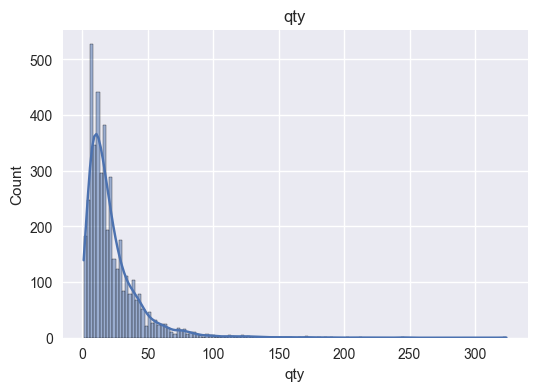

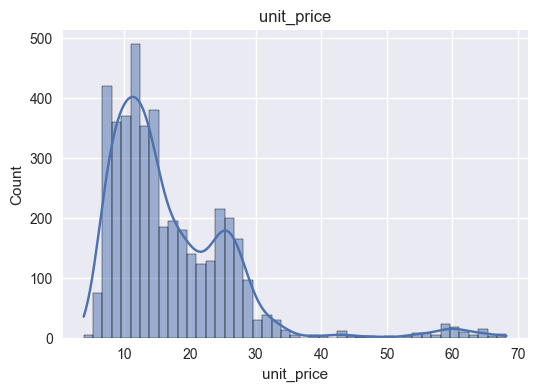

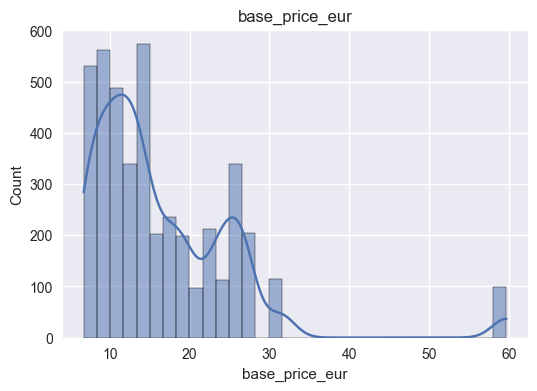

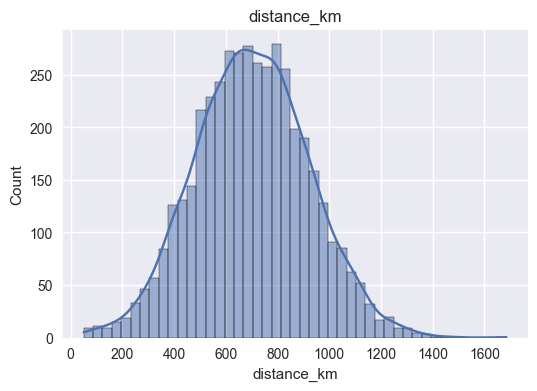

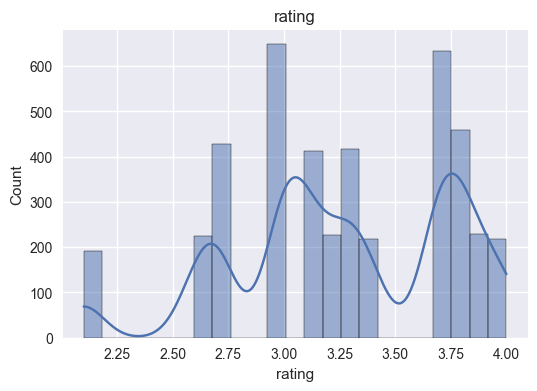

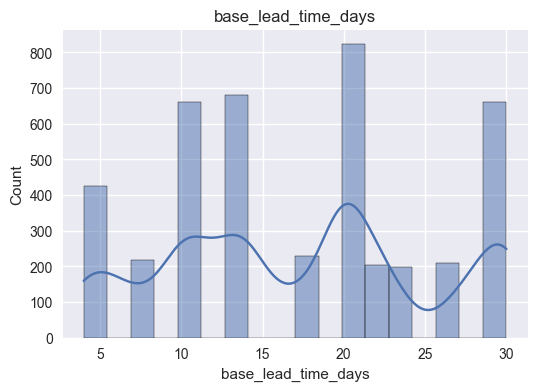

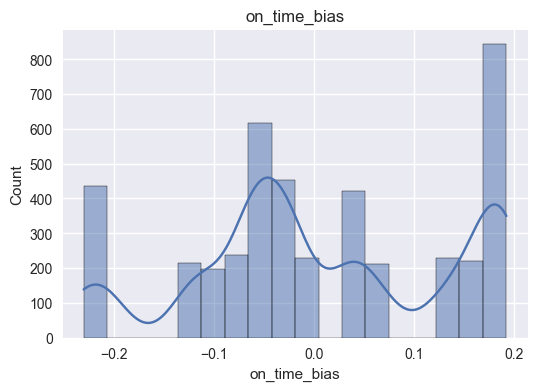

In [10]:
for col in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(po[col], kde=True)
    plt.title(col)
    plt.show()

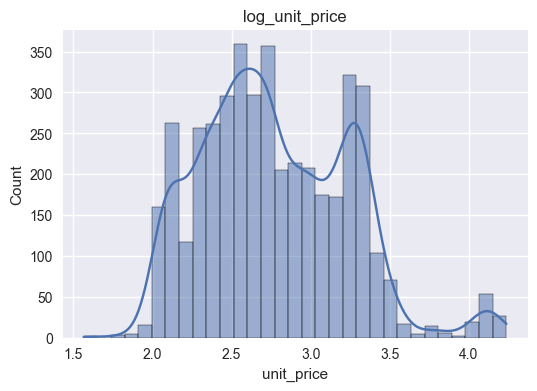

In [11]:
plt.figure(figsize=(6,4))
sns.histplot(np.log1p(po["unit_price"]), kde=True)
plt.title("log_unit_price")
plt.show()

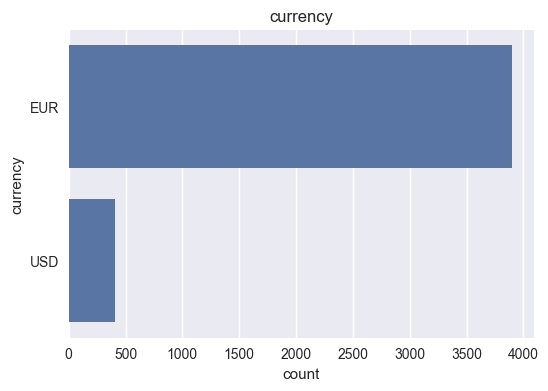

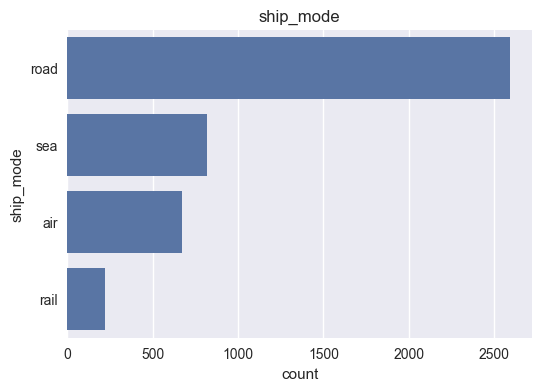

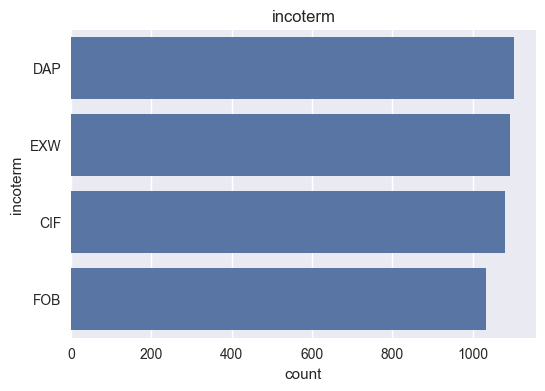

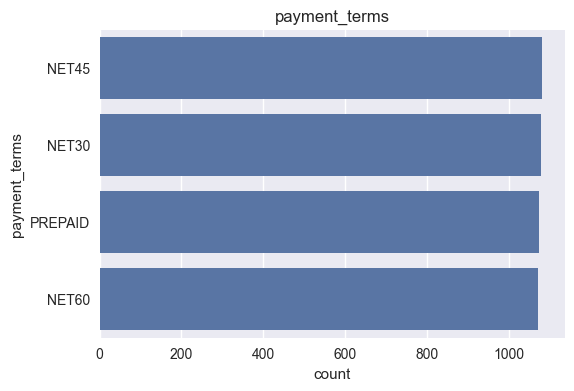

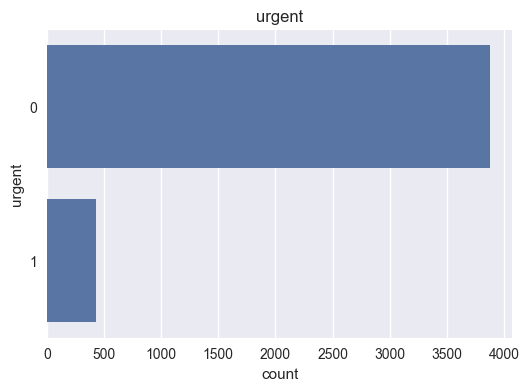

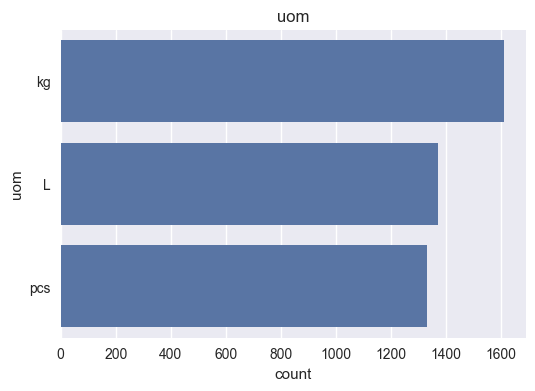

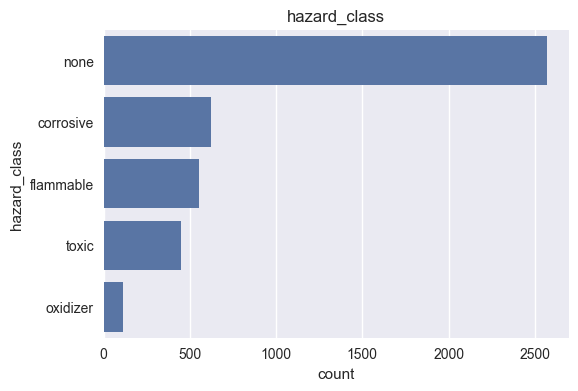

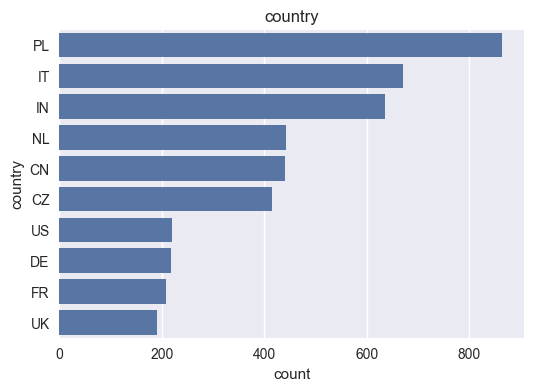

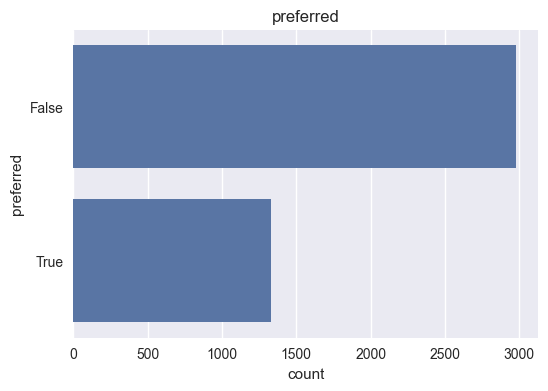

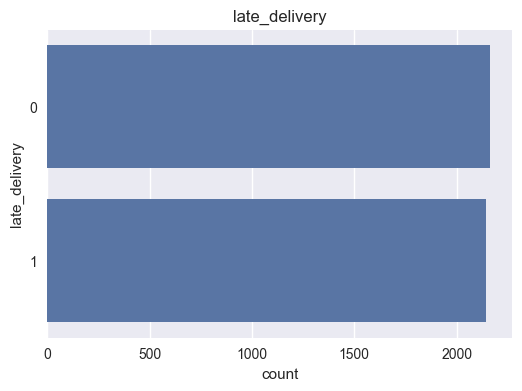

In [12]:
for col in categorical_features:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=po, order=po[col].value_counts().index)
    plt.title(col)
    plt.show()

### 6. Analyze late deliveries patterns

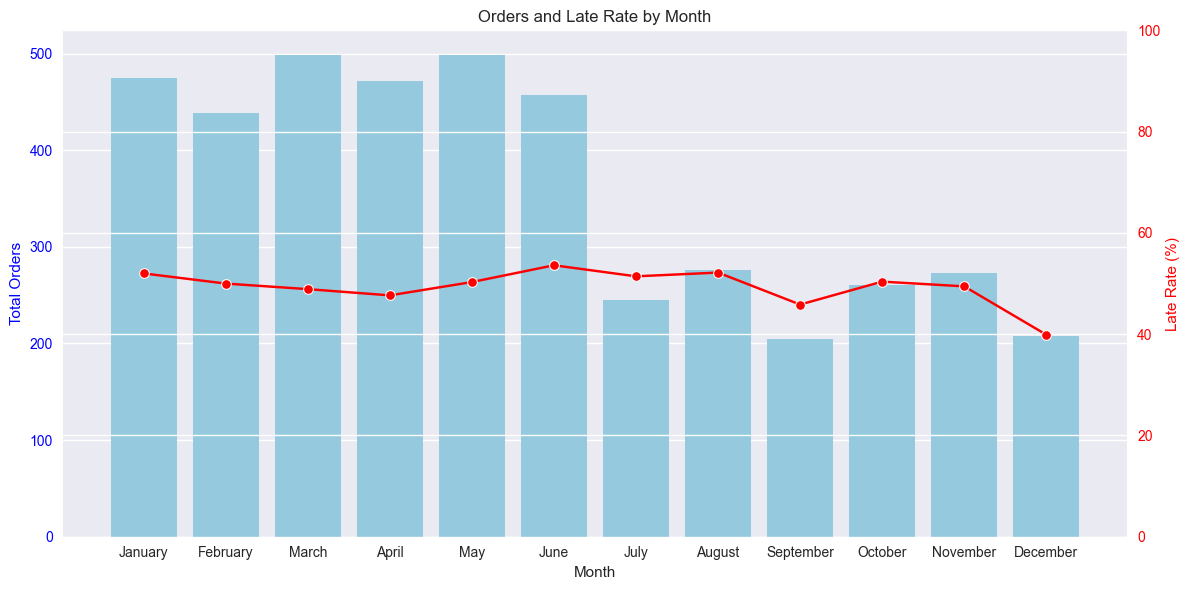

In [13]:
po["month"] = df["order_date"].dt.month_name()

monthly_stats = po.groupby("month").agg(
    total_orders=("late_delivery", "count"),
    late_orders=("late_delivery", "sum")
)
monthly_stats["late_rate"] = monthly_stats["late_orders"] * 100 / monthly_stats["total_orders"]

month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]
monthly_stats = monthly_stats.reindex(month_order)

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=monthly_stats.index, y="total_orders", data=monthly_stats, color="skyblue", ax=ax1)
ax1.set_ylabel("Total Orders", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(x=monthly_stats.index, y="late_rate", data=monthly_stats, color="red", marker="o", ax=ax2)
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 100)

plt.title("Orders and Late Rate by Month")
ax1.set_xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Order volumes peak in March and May (around 500 orders each), while September and December have the lowest volumes
##### Late delivery rate stays relatively stable, ranging between 40% and 60%, with June showing the highest rate (58%) despite high order volumes
##### No strong seasonality pattern in late deliveries, thus late rate does not directly correlate with order volume

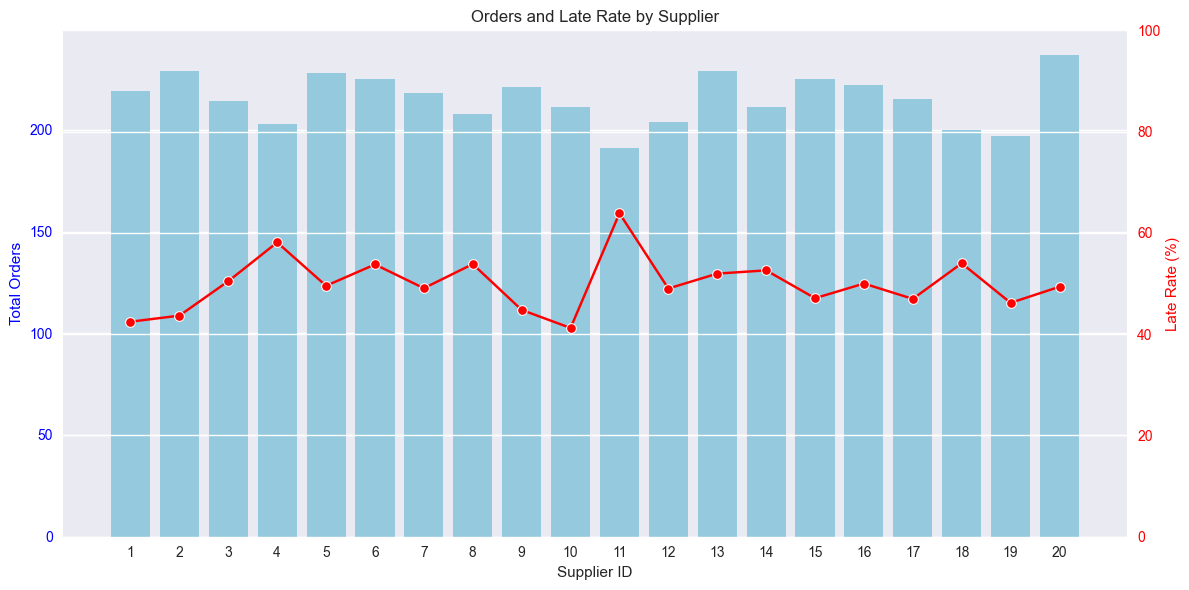

In [14]:
supplier_stats = po.groupby("supplier_id").agg(
    total_orders=("late_delivery", "count"),
    late_orders=("late_delivery", "sum")
)
supplier_stats.index = supplier_stats.index.astype(str)
supplier_stats["late_rate"] = supplier_stats["late_orders"] * 100 / supplier_stats["total_orders"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=supplier_stats.index, y="total_orders", data=supplier_stats, color="skyblue", ax=ax1)
ax1.set_ylabel("Total Orders", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(x=supplier_stats.index, y="late_rate", data=supplier_stats, color="red", marker="o", ax=ax2)
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 100)

plt.title("Orders and Late Rate by Supplier")
ax1.set_xlabel("Supplier ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Most suppliers handle 200–230 orders, showing balanced distribution
##### Supplier 11 has the highest late rate (65%), despite handling fewer orders
##### Other suppliers like Supplier 4 and 18 also show high late rates (55–60%)
##### Indicates supplier-specific performance issues rather than systemic delays

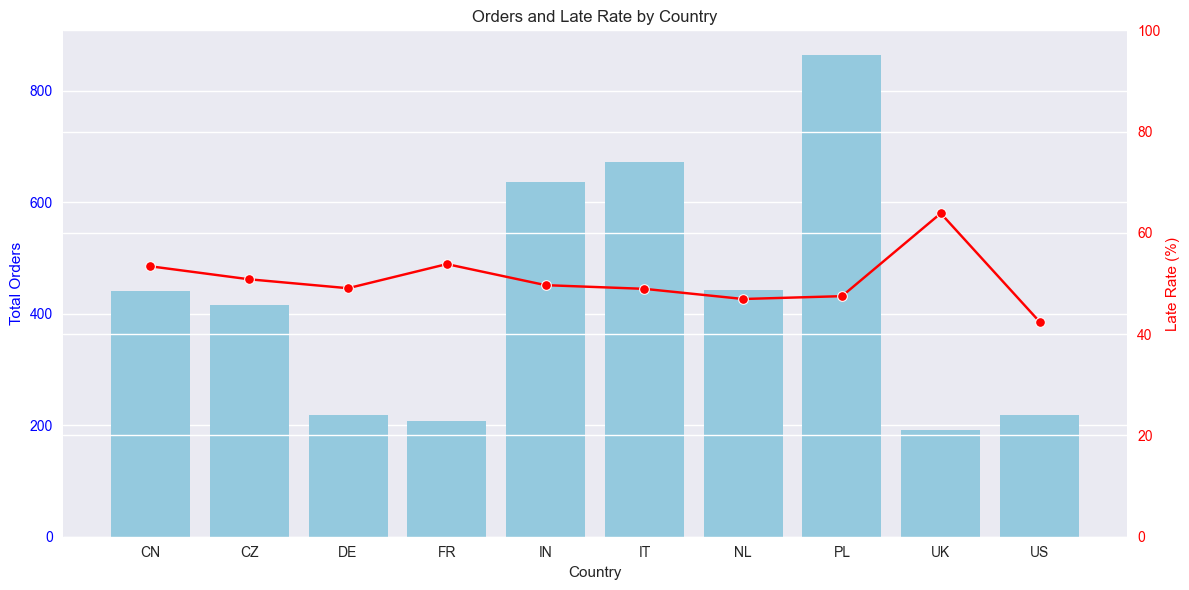

In [15]:
country_stats = po.groupby("country").agg(
    total_orders=("late_delivery", "count"),
    late_orders=("late_delivery", "sum")
)
country_stats.index = country_stats.index.astype(str)
country_stats["late_rate"] = country_stats["late_orders"] * 100 / country_stats["total_orders"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=country_stats.index, y="total_orders", data=country_stats, color="skyblue", ax=ax1)
ax1.set_ylabel("Total Orders", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(x=country_stats.index, y="late_rate", data=country_stats, color="red", marker="o", ax=ax2)
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 100)

plt.title("Orders and Late Rate by Country")
ax1.set_xlabel("Country")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Poland (PL) dominates in order volume (870 orders), followed by Italy (IT) and India (IN)
##### England (UK) has the highest late rate (65%), despite having the lowest order count, signaling severe delivery issues there
##### China (CN) and France (FR) show moderate late rates (50%), while US has the lowest (40%)
##### Late delivery seems more influenced by supplier country than by total order volume

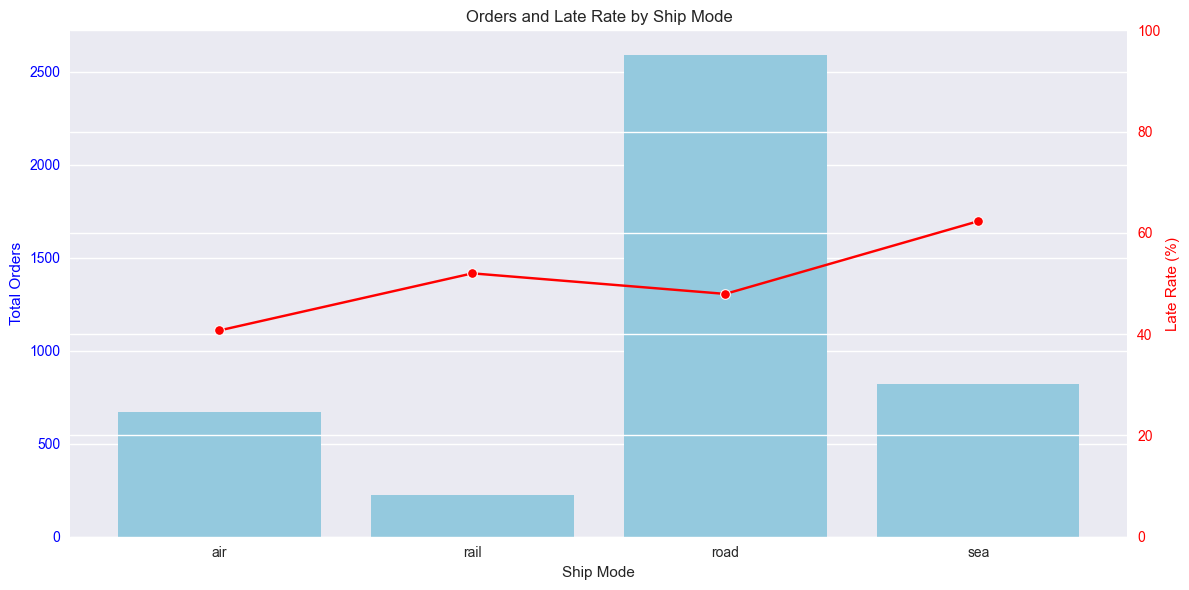

In [16]:
ship_mode_stats = po.groupby("ship_mode").agg(
    total_orders=("late_delivery", "count"),
    late_orders=("late_delivery", "sum")
)
ship_mode_stats.index = ship_mode_stats.index.astype(str)
ship_mode_stats["late_rate"] = ship_mode_stats["late_orders"] * 100 / ship_mode_stats["total_orders"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=ship_mode_stats.index, y="total_orders", data=ship_mode_stats, color="skyblue", ax=ax1)
ax1.set_ylabel("Total Orders", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(x=ship_mode_stats.index, y="late_rate", data=ship_mode_stats, color="red", marker="o", ax=ax2)
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 100)

plt.title("Orders and Late Rate by Ship Mode")
ax1.set_xlabel("Ship Mode")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Road dominates in terms of order count, followed by sea, air, and rail (smallest volume)
##### Rail and sea show the highest late rates (50–65%), while air has the lowest (40%). Despite its cost, air is more reliable for on-time delivery
##### Road, while most common, has moderate late rates (45%)

/var/folders/0h/7_2sn6jj15xfw1h8m20d0psc0000gn/T/ipykernel_38339/2832115024.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_band_stats = po.groupby("distance_band").agg(


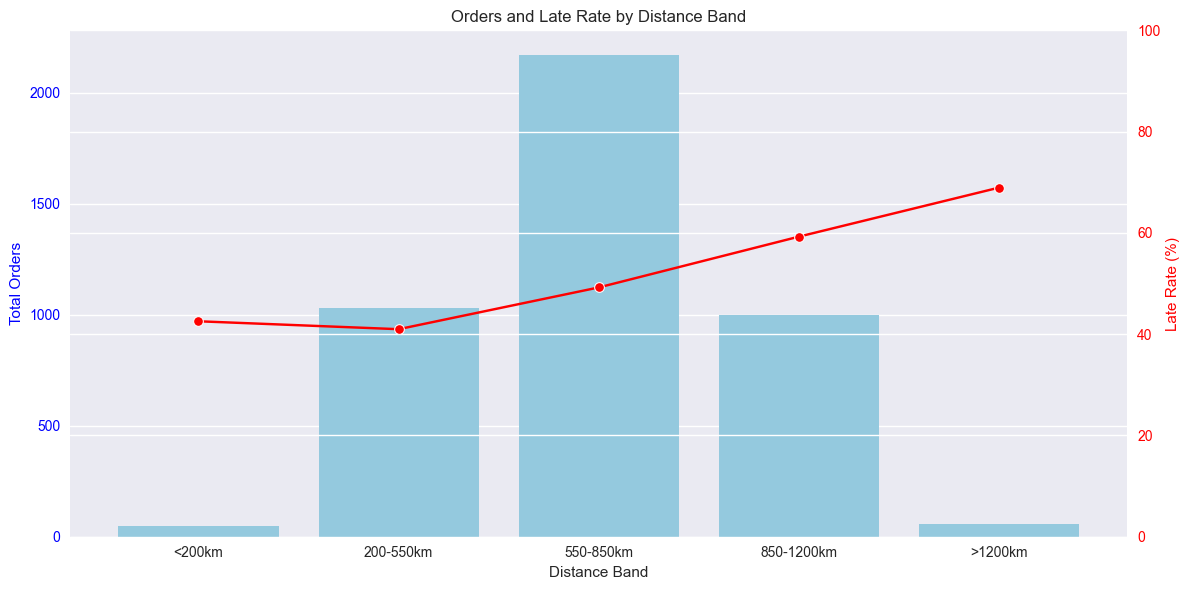

In [17]:
bins = [0, 200, 550, 850, 1200, 2000]
labels = ["<200km", "200-550km", "550-850km", "850-1200km", ">1200km"]
po["distance_band"] = pd.cut(po["distance_km"], bins=bins, labels=labels)

distance_band_stats = po.groupby("distance_band").agg(
    total_orders=("late_delivery", "count"),
    late_orders=("late_delivery", "sum")
)
distance_band_stats.index = distance_band_stats.index.astype(str)
distance_band_stats["late_rate"] = distance_band_stats["late_orders"] * 100 / distance_band_stats["total_orders"]

fig, ax1 = plt.subplots(figsize=(12, 6))

sns.barplot(x=distance_band_stats.index, y="total_orders", data=distance_band_stats, color="skyblue", ax=ax1)
ax1.set_ylabel("Total Orders", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

ax2 = ax1.twinx()
sns.lineplot(x=distance_band_stats.index, y="late_rate", data=distance_band_stats, color="red", marker="o", ax=ax2)
ax2.set_ylabel("Late Rate (%)", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.set_ylim(0, 100)

plt.title("Orders and Late Rate by Distance Band")
ax1.set_xlabel("Distance Band")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Most orders fall within the 550–850 km range, followed by 200–550 km and 850–1200 km. Very few orders are under 200 km or above 1200 km
##### The late rate (%) increases with distance, starting from ~40% for short distances and exceeding 65% for >1200 km. This indicates that longer distances are a strong driver of delays

### 7. Potential leakage risks

##### When predicting late deliveries, leakage can happen if we use future or outcome-related data. For example we can not include columns (actual_delivery_date, delay_days, partial_delivery, cancelled, delay_reason) from deliveries table as features or use any features derived from them
##### Also if we randomly split data into train/test, the model could learn patterns from future months that wouldn’t be available at prediction time
##### Safe predictive features from purchase_orders: month, qty, unit_price, currency, ship_mode, incoterm, payment_terms, distance_km, urgent
##### Safe predictive features from suppliers: preferred, rating, base_lead_time_days, on_time_bias
##### Safe predictive features from products: uom, hazard_class, base_price_eur